## Basic Training

In [1]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, classification_report

import numpy as np
import pandas as pd

In [39]:
hmhas = pd.read_csv('dataset/h_mas_train.csv')

In [40]:
hmhas = hmhas.drop('Unnamed: 0', axis=1)

In [41]:
hmhas.columns

Index(['cholst', 'mobila', 'nagi10', 'hrtatte', 'nagi8', 'iadlfour', 'push',
       'bmi', 'walks', 'rxhrtat', 'grossa', 'walkr', 'rxdiabi', 'iadlfoura',
       'hip_m', 'hhid', 'mobilsev', 'atotb', 'hhidc', 'fallinj', 'shopa',
       'itot', 'agey', 'wtresp', 'rxhibp', 'ctot1m', 'atotf', 'hltc', 'weight',
       'grossaa', 'adla_m', 'momage', 'height', 'bath', 'dadage', 'atoth',
       'adlaa_m', 'shlt', 'ahous', 'hosp1y'],
      dtype='object')

# Preprocessing

In [42]:
df = hmhas

from sklearn.model_selection import train_test_split

X_train = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_train

y_train = df["hosp1y"]

# Remove the 'target' column for test
X_test = df.drop("hosp1y", axis=1)

# Assign the 'target' column to y_test
y_test = df["hosp1y"]

# separate dataset into train and test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)


In [43]:
#Drop Categorical :
categorical_cols = X_train.select_dtypes(include=['object']).columns

X_train = X_train.drop(categorical_cols, axis=1)
X_test = X_test.drop(categorical_cols, axis=1)
X_val = X_val.drop(categorical_cols, axis=1)

In [44]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Impute values for all columns with missing data
imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp_mean.fit(X_train)

n_train_df = imp_mean.transform(X_train)
t_val_df = imp_mean.transform(X_val)
t_test_df = imp_mean.transform(X_test)

# Scaling all Numerical features

scaler = StandardScaler()
scaler = scaler.fit(n_train_df)

t_train_df = scaler.transform(n_train_df)
t_val_df = scaler.transform(t_val_df)
t_test_df = scaler.transform(t_test_df)


In [92]:
%%time

# This is an example code on how to:
#   - Create and fit (train) a logistic regression
#   - Assign to `log_reg` variable
log_reg = None
log_reg = LogisticRegression(C=0.01)
log_reg.fit(t_train_df, y_train)


CPU times: total: 1.44 s
Wall time: 665 ms


LogisticRegression(C=0.01)

In [93]:
log_reg_train = log_reg.predict_proba(t_train_df)[:, 1]

In [94]:
roc_auc_train = roc_auc_score(y_true=y_train, y_score=log_reg_train)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.7378


# Multiple Training

In [48]:
import lightgbm as lgb

In [49]:
%%time

models = {
    "Logistic Regression": LogisticRegression(C=0.001),
    "      Random Forest": RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42),
    "      LGBClassifier ": lgb.LGBMClassifier(learning_rate=0.2)
}

for name, model in models.items():
    model.fit(t_train_df, y_train)
    print(name + " trained.")

Logistic Regression trained.
      Random Forest trained.
[LightGBM] [Info] Number of positive: 9248, number of negative: 67198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011143 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3143
[LightGBM] [Info] Number of data points in the train set: 76446, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120974 -> initscore=-1.983236
[LightGBM] [Info] Start training from score -1.983236
      LGBClassifier  trained.
CPU times: total: 30.7 s
Wall time: 30.6 s


# Results

In [50]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    acc = accuracy_score(y_test, y_pred)
    print(name + " Accuracy: {:.2f}%".format(acc * 100))

Logistic Regression Accuracy: 88.09%
      Random Forest Accuracy: 89.26%
      LGBClassifier  Accuracy: 90.14%


In [51]:
for name, model in models.items():
    y_pred = model.predict(t_test_df)
    f1 = f1_score(y_test, y_pred)
    print(name + " F1-Score: {:.5f}".format(f1))

Logistic Regression F1-Score: 0.10617
      Random Forest F1-Score: 0.19816
      LGBClassifier  F1-Score: 0.33519


## Neural NetWork Training

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [ ]:
model = Sequential()

model.add(Flatten())

model.add(Dense(512, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=5e-3), metrics=['accuracy'])    

epochs = 30
batch_size = 32

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True,),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{accuracy:.3f}.h5', save_best_only=True),
]

model.fit(t_train_df, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=my_callbacks)

mlp = model

# Send the input data through the trained model to get the predictions
predictions = mlp.predict(t_test_df)

In [79]:
predictions.shape

(95558, 1)

## Classification Report

In [80]:
# Extract the probabilities

p_pred = predictions.flatten()

# Extract the Class labels
y_pred = np.where(p_pred > 0.5, 1, 0)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95     84050
         1.0       0.81      0.27      0.41     11508

    accuracy                           0.91     95558
   macro avg       0.86      0.63      0.68     95558
weighted avg       0.90      0.91      0.88     95558



## Confusion Matrix

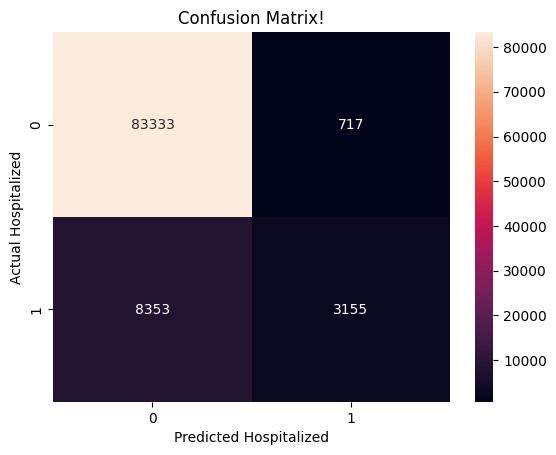

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

matc=confusion_matrix(y_test, y_pred)

ax = sns.heatmap(matc, annot=True, fmt='g')

ax.set_title('Confusion Matrix!')
ax.set_xlabel('Predicted Hospitalized')
ax.set_ylabel('Actual Hospitalized')

# Plot the confusion matrix

plt.show()

In [100]:
roc_auc_train = roc_auc_score(y_true=y_test, y_score=predictions)

print(f"Train ROC AUC Score: {roc_auc_train:.4f}") 

Train ROC AUC Score: 0.8508
